<a href="https://www.kaggle.com/code/robertovicario/the-musk-effect-on-crypto-a-data-driven-analysis?scriptVersionId=215016146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# The Musk Effect on Crypto: A Data-Driven Analysis

## Visualizations

### Candlesticks

In [268]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from PIL import Image
from mplfinance.original_flavor import candlestick_ohlc
from wordcloud import WordCloud
import requests
from io import BytesIO

def plot_candlestick(df, start_date, end_date, title=None, time_period=None, tweets=None):
    filtered_df = df.set_index('Timestamp').loc[start_date:end_date]
    filtered_df = (
        filtered_df.resample('D')
        .agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum',
        })
        .dropna()
    )

    filtered_df['Date'] = filtered_df.index.map(mdates.date2num)
    ohlc_data = filtered_df[['Date', 'Open', 'High', 'Low', 'Close']].reset_index(drop=True).values
    highest_value = filtered_df['High'].max()
    lowest_value = filtered_df['Low'].min()

    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    colorup = '#4CAF50'
    colordown = '#F44336'

    candlestick_ohlc(ax1, ohlc_data, width=0.5, colorup=colorup, colordown=colordown)
    ax1.grid(True, linestyle='-', alpha=0.1, color='black', linewidth=0.5)
    ax1.axhline(highest_value, color=colorup, linestyle='--', linewidth=2, label=f'Highest: {highest_value}')
    ax1.axhline(lowest_value, color=colordown, linestyle='--', linewidth=2, label=f'Lowest: {lowest_value}')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis_date()
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    ax1.set_title(title)
    ax1.set_ylabel('Price (USD)')
    ax1.set_xlabel(time_period)
    ax1.legend()

    if tweets:
        for start_date, end_date in tweets:
            i = mdates.date2num(pd.to_datetime(start_date))
            j = mdates.date2num(pd.to_datetime(end_date))
            ax1.axvspan(i, j, color='#1DA1F2', alpha=0.1)

    for i, row in filtered_df.iterrows():
        if row['Close'] > row['Open']:
            color = colorup
        else:
            color = colordown
        
        ax2.bar(i, row['Volume'], color=color)

    ax2.grid(True, axis='y', linestyle='-', alpha=0.1, color='black', linewidth=0.5)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel(time_period)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

    plt.tight_layout()
    plt.show()

### WordClouds

In [269]:
def plot_wordcloud(df, crypto_name=''):
    filtered_df = df[df['Tweet'].str.contains(crypto_name, case=False, na=False)]
    tweets = ' '.join(filtered_df['Tweet'].dropna())
    tweets = tweets.replace('BTC', 'Bitcoin').replace('DOGE', 'Doge')

    keywords_colors = {
        'Bitcoin': '#F7931A',
        'Doge': '#BA9F33',
        'Tesla': '#E82127',
        'SpaceX': '#004B87',
    }
    keyword_counts = {keyword: tweets.lower().count(keyword.lower()) for keyword in keywords_colors}
    word_frequencies = {}
    for word, count in keyword_counts.items():
        word_frequencies[word] = count * 100
    for word in re.findall(r'\w+', tweets):
        word_frequencies[word] = word_frequencies.get(word, 0) + 1

    url = 'https://raw.githubusercontent.com/robertovicario/uninsubria-DataVisualization-Project-Work/main/assets/img/twitter.png'
    response = requests.get(url)
    bg_img = Image.open(BytesIO(response.content)).convert('L')
    mask = np.array(bg_img)

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if word in keywords_colors:
            return keywords_colors[word]
        else:
            return '#C0C0C0'

    wordcloud = WordCloud(background_color='white',
                        mask=mask,
                        max_words=10000,
                        color_func=color_func,
                        contour_color='#1DA1F2',
                        contour_width=2,
                        relative_scaling=0.5).generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## EDA (Exploratory Data Anaysis)

### Dependencies

In [270]:
import pandas as pd
btc_prices_2021 = pd.read_csv('kaggle/input/from-tweets-to-trends-the-musk-effect-on-crypto/btc_prices_2021.csv')
btc_prices_2024 = pd.read_csv('kaggle/input/from-tweets-to-trends-the-musk-effect-on-crypto/btc_prices_2024.csv')
doge_prices = pd.read_csv('kaggle/input/from-tweets-to-trends-the-musk-effect-on-crypto/doge_prices.csv')
musk_tweets = pd.read_csv('kaggle/input/from-tweets-to-trends-the-musk-effect-on-crypto/musk_tweets.csv')

### BTC Prices Dataset Overview

In [271]:
btc_prices = pd.concat([btc_prices_2021, btc_prices_2024], ignore_index=True)
btc_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935185 entries, 0 to 935184
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Timestamp  935185 non-null  object 
 1   Open       935185 non-null  float64
 2   High       935185 non-null  float64
 3   Low        935185 non-null  float64
 4   Close      935185 non-null  float64
 5   Volume     935185 non-null  float64
dtypes: float64(5), object(1)
memory usage: 42.8+ MB


### DOGE Prices Dataset Overview

In [272]:
doge_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  2335 non-null   object 
 1   Open       2334 non-null   float64
 2   High       2334 non-null   float64
 3   Low        2334 non-null   float64
 4   Close      2334 non-null   float64
 5   Volume     2334 non-null   float64
dtypes: float64(5), object(1)
memory usage: 109.6+ KB


### Musk Tweets Dataset Overview

In [273]:
musk_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  5904 non-null   object
 1   Tweet      5904 non-null   object
 2   Followers  5904 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 138.5+ KB


## Tesla Episode on Bitcoin (2021)

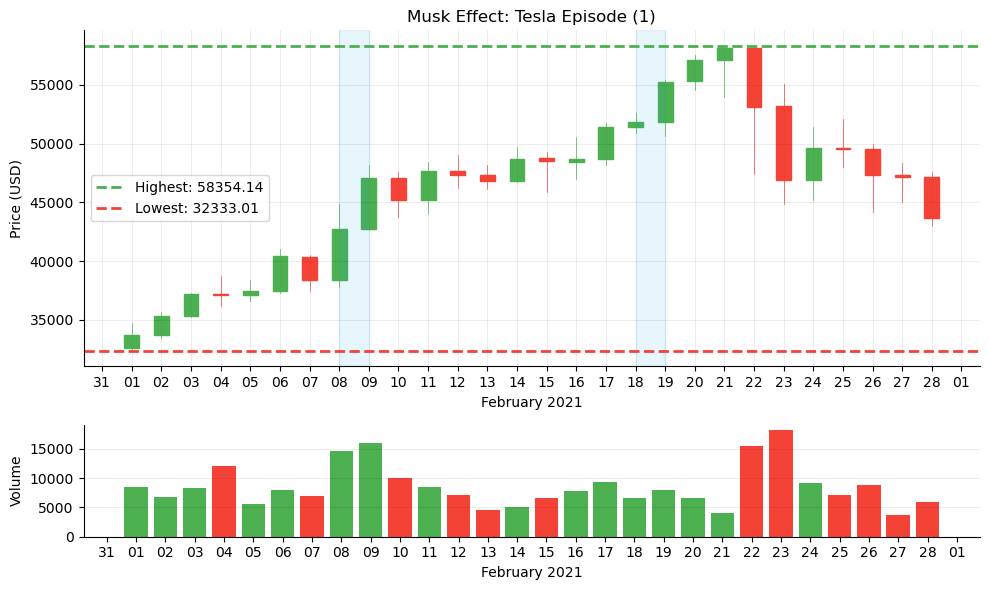

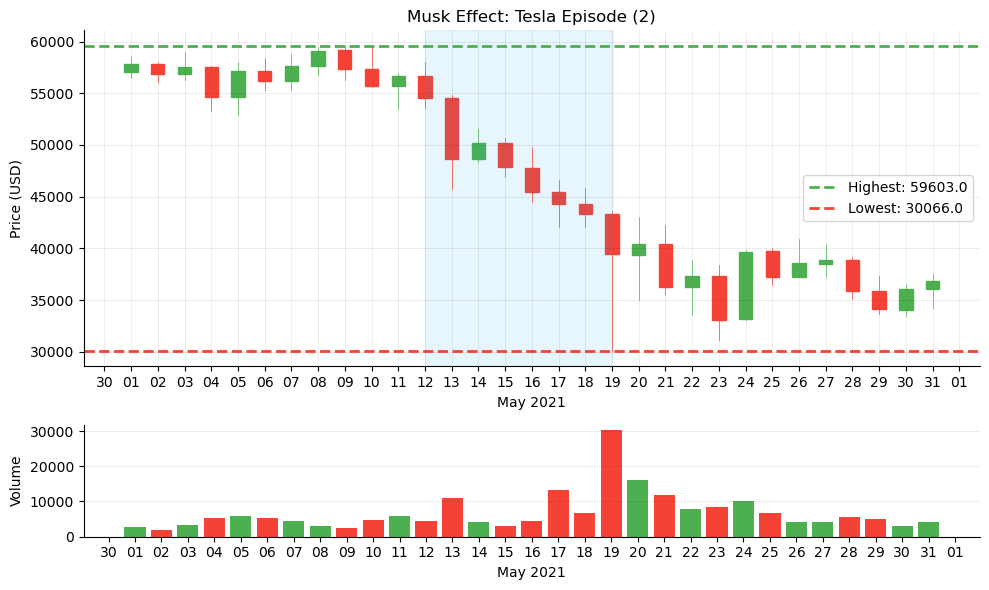

In [274]:
import pandas as pd
bitcoin_2021_df = pd.read_csv('kaggle/input/from-tweets-to-trends-the-musk-effect-on-crypto/btc_prices_2021.csv', parse_dates=['Timestamp'])
bitcoin_2024_df = pd.read_csv('kaggle/input/from-tweets-to-trends-the-musk-effect-on-crypto/btc_prices_2024.csv', parse_dates=['Timestamp'])

start_date = '2021-02-01'
end_date = '2021-02-28'
title = 'Musk Effect: Tesla Episode (1)'
time_period = 'February 2021'
tweets = [
    ('2021-02-08', '2021-02-09'),
    ('2021-02-18', '2021-02-19')
]
plot_candlestick(bitcoin_2021_df, start_date, end_date, title, time_period, tweets)

start_date = '2021-05-01'
end_date = '2021-05-31'
title = 'Musk Effect: Tesla Episode (2)'
time_period = 'May 2021'
tweets = [('2021-05-12', '2021-05-19')]
plot_candlestick(bitcoin_2021_df, start_date, end_date, title, time_period, tweets)

## Elon Tweets: An Overview

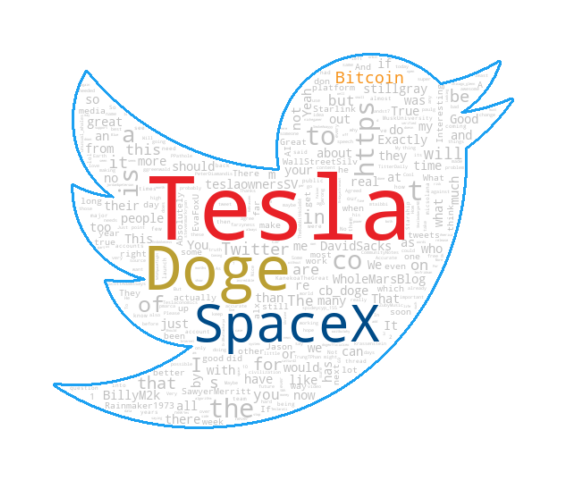

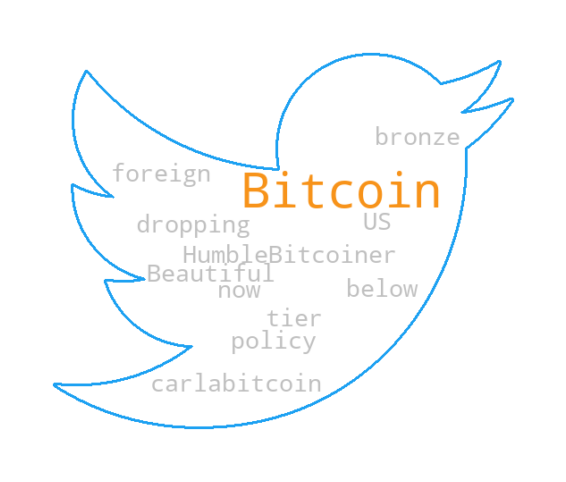

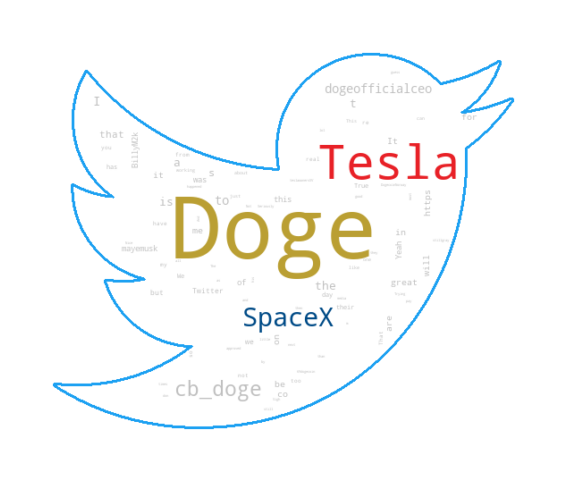

In [275]:
import pandas as pd
musk_tweets = pd.read_csv('kaggle/input/from-tweets-to-trends-the-musk-effect-on-crypto/musk_tweets.csv')

plot_wordcloud(musk_tweets)
plot_wordcloud(musk_tweets, 'Bitcoin')
plot_wordcloud(musk_tweets, 'Doge')